# Setup and Utilties

In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.preprocessing
import scipy
from tqdm import tqdm

import multiprocessing

import ast
import collections
import os
import shutil
import pickle

import matplotlib as plt
import seaborn as sb

from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cd '/content'
!mkdir './project_data/'
!mkdir './project_data/inside_airbnb/'
!mkdir './project_data/inside_airbnb/united-states/'

# Getting CA data
!cp '/content/drive/MyDrive/CS 6220/Project/ca.zip' './project_data/inside_airbnb/united-states/'
!cd './project_data/inside_airbnb/united-states/'
!n | unzip './project_data/inside_airbnb/united-states/ca.zip' -d './project_data/inside_airbnb/united-states/'
!rm -rf './project_data/inside_airbnb/united-states/__MACOSX/'

# Getting DC data
!mkdir './project_data/inside_airbnb/united-states/dc/'
!cp -r '/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/dc/washington-dc' './project_data/inside_airbnb/united-states/dc/'
clear_output()

Declare your state and city for everything else below

In [106]:
# Declare your state and city
state = "dc"
city = "washington-dc"

# Set this to true if you want to calculate/save CSVs.
# Set this to false if you just want to load pre-existing data.
make_csvs = False

In [107]:
# Load data from a file to a pandas dataframe
def load_data(state='ca', city='los-angeles'):
    datasource = f"/content/project_data/inside_airbnb/united-states/{state}/{city}/listings.csv"
    return pd.read_csv(datasource)

# Remove columns not used for models.
# Format numerical string data into numerical datatypes
# Format t/f into binary representation
def clean_and_drop(df, drop_price=False, drop_amenities=True):
    df = df.drop([ 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
                'neighborhood_overview', 'neighbourhood_group_cleansed', 'picture_url', 'host_id', 'host_url',
                'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                'host_neighbourhood','bathrooms', #'neighbourhood', 'id',
                'calendar_last_scraped', 'first_review', 'last_review', 'license', 'host_verifications', 'calendar_updated'], axis="columns")



    df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float') / 100.0
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype('float')
    if drop_price:
        df = df.drop('price', axis="columns")
    if drop_amenities:
        df = df.drop('amenities', axis="columns")
    
    df.host_is_superhost = df.host_is_superhost.map({'t':1, "f":0})
    df.host_has_profile_pic = df.host_has_profile_pic.map({'t':1, "f":0})
    df.host_identity_verified = df.host_identity_verified.map({'t':1, "f":0})
    df.has_availability = df.has_availability.map({'t':1, "f":0})
    df.instant_bookable = df.instant_bookable.map({'t':1, "f":0})

    # Predicting on only variables that contribute [Drop any with p-vals > 0.05]
    df = df.drop(['instant_bookable', 'review_scores_location', 'review_scores_communication', 'review_scores_cleanliness',
                'review_scores_accuracy', 'review_scores_rating', 'number_of_reviews_l30d', 'number_of_reviews',
                'has_availability', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights',
                'maximum_nights', 'minimum_nights', 'property_type', 'host_identity_verified',
                'host_has_profile_pic', 'host_is_superhost', 'host_response_rate', 'host_response_time'], axis="columns")

    return df

# Returns a set of all amenities
def get_amenities_set(df):
    amenities = set()
    for r in df.amenities:
        amenities = amenities.union(set(ast.literal_eval(r)))
    return amenities

# Returns a dict of {amenity: # of occurances in all rental properties in df}
def get_amenities_dict(df, cutoff=25):
    amenities = collections.Counter()
    for r in df.amenities:
        amenities.update(ast.literal_eval(r))
    return dict(collections.Counter({a: c for a, c in amenities.items() if c >= cutoff}))

def create_and_populate_amenity_cols(df):
    cutoff=1000
    amenities = [s.lower() for s in list(get_amenities_dict(df, cutoff).keys())]
    ndf = df.copy()
    ndf = pd.concat(
    [
        ndf,
        pd.DataFrame(
            [[0] * len(amenities)], 
            index=ndf.index, 
            columns=amenities
        )
    ], axis=1
    )
    counter = 0
    for r in tqdm(ndf.index): # Set value of all amenities a rental has to 1, rest 0
        if not pd.isnull(ndf.loc[r, 'amenities']):
            ams_list = [s.lower() for s in ast.literal_eval(ndf.loc[r, 'amenities']) if s.lower() in amenities]
            ams_dict = {a: 0 for a in amenities}
            for a in ams_list:
                ams_dict[a] = 1
            ndf.loc[r, ams_dict.keys()] = ams_dict.values()
    ndf = ndf.drop(columns=['amenities'])
    return ndf

def fix_dtypes(df):
  for c in df.columns:
    dtype = df[c].dtype
    if dtype == 'int64':
      df[c] = df[c].astype('int32')
    if dtype == 'float64':
      df[c] = df[c].astype('float32')
  return df

# Data Encoding

Run this section to get the data for the city you've selected. Might just load data from CSVs or might generate the CSVs based on your settings above.

In [108]:
loaded_data = load_data(state, city)

In [109]:
df_onehot = None
if make_csvs:
  df_onehot = clean_and_drop(loaded_data, False, False)

  categorical_cols = ["bathrooms_text", "room_type"]

  df_onehot = pd.get_dummies(df_onehot, columns=categorical_cols).dropna()
  print(len(df_onehot), "properties")

  df_onehot = create_and_populate_amenity_cols(df_onehot)
  df_onehot.to_csv(f'/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/{state}/{city}/{city}-NO-NA.csv', errors='surrogatepass')

## Data Loading

In [110]:
# Set path to city dir
city_dir = f"/content/project_data/inside_airbnb/united-states/{state}/{city}/"

# THIS IS MY SPECIFIC PATH. CHANGE IF YOU AREN'T ME
drive_dir = f"/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/{state}/{city}/"

In [111]:
# For loading from CSV
shutil.copy(f'/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/{state}/{city}/{city}-NO-NA.csv', f'/content/project_data/inside_airbnb/united-states//{state}/{city}/{city}-NO-NA.csv')

'/content/project_data/inside_airbnb/united-states//dc/washington-dc/washington-dc-NO-NA.csv'

In [112]:
# To load without locations:
df_onehot = pd.read_csv(os.path.join(city_dir, f'{city}-NO-NA.csv'))

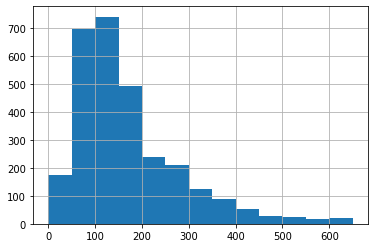

In [113]:
hist_cutoffs = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
x_label = 'Property Price'
y_label = 'Property Count'
price = df_onehot.price
price.hist(bins=hist_cutoffs)

## Create location features

In [114]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import geopy.distance

#listings_filepath refers to the original listings file (unmodified) downloaded from kaggle
#onehot_filepath refers to the dataset output by running connor's one-hot encoding code above
def create_all_location_features(listings_filepath, onehot, min_price=30, max_price=500):
    #Read in the dataset
    la = pd.read_csv(listings_filepath)
    
    # === Preprocessing ===
    la['price'] = la['price'].map(lambda x: float(x.replace('$','').replace(',','')))
    
    #Get rid of extreme price outliers
    la = la[(la['price'] > min_price) & (la['price'] < max_price)]
    
    la = create_neighborhood_avg_price(la)
    
    la = create_cluster_avg_price(la)
    
    la = create_nearby_avg_price(la)
    
    # la = create_distance_to_pois(la)
    
    df_onehot = merge_with_onehot(la, onehot, min_price, max_price)
    
    return df_onehot
    
    
def create_neighborhood_avg_price(la):
    la_locations = la[['longitude','latitude']]
    
    neighborhood_averages = {}
    neighbourhood_counts = {}

    for neighborhood in la['neighbourhood_cleansed'].unique():
        neighborhood_averages[neighborhood] = la[la['neighbourhood_cleansed'] == neighborhood]['price'].mean()
        neighbourhood_counts[neighborhood] = len(la[la['neighbourhood_cleansed'] == neighborhood])

    la['neighbourhood_average_price'] = la['neighbourhood_cleansed'].map(neighborhood_averages)
    la['num_in_neighbourhood'] = la['neighbourhood_cleansed'].map(neighbourhood_counts)
    
    return la


def create_cluster_avg_price(la):
    la_locations = la[['longitude','latitude']]
    
    clustering = DBSCAN(eps=.01).fit(la_locations)
    la['cluster_number'] = clustering.labels_

    #Get average price of each cluster
    cluster_averages = {}
    for i in la['cluster_number'].unique():
        cluster_averages[i] = la[la['cluster_number']==i]['price'].mean()

    la['cluster_average_price'] = la['cluster_number'].map(cluster_averages)
    
    #include number in cluster too
    cluster_counts = {}
    for cluster in la['cluster_number'].unique():
        cluster_counts[cluster] = len(la[la['cluster_number'] == cluster])

    la['num_in_cluster'] = la['cluster_number'].map(cluster_counts)
    
    la = la.drop(['cluster_number'],axis='columns')

    return la

def create_nearby_avg_price(la):
    la_locations = la[['longitude','latitude']]
    
    knn = NearestNeighbors(n_neighbors=10)
    knn.fit(la_locations)

    distances, indices = knn.kneighbors(la_locations)

    #Could tweak this to only include properties within a certain distance of each other
    avg_nearby_prices = [0] * len(la_locations)
    for i in range(len(indices)):
        closest_points = indices[i,1:]
        avg_nearby_prices[i] = la.iloc[closest_points]['price'].mean()

    la['nearby_average_price'] = avg_nearby_prices
    
    return la

def create_distance_to_pois(la):
    points_of_interest = [(34.011535661131354, -118.50198735702507),
                      (34.047548066330336, -118.5633340820288),
                      (34.071312584445586, -118.35770894822),
                      (34.07931102198564, -118.47415412068081),
                      (34.0675483525067, -118.36083308699335),
                      (34.10471281374351, -118.34294029255402),
                      (34.11858649819086, -118.29835031188001),
                      (34.05648995479435, -118.24864810412235),
                      (34.045352,-118.245733),
                      (la['latitude'].mean(), la['longitude'].mean())]
    
    for i in range(len(points_of_interest)):
        column_name = 'dist_to_poi_' + str(i)
        poi_coord = points_of_interest[i]

        distances_to_poi = [0] * len(la)

        j = 0
        for lat,long in zip(la['latitude'],la['longitude']):
            distances_to_poi[j] = geopy.distance.geodesic(poi_coord,(lat,long))
            j+=1

        la[column_name] = [float(str(x).replace(' km','')) for x in distances_to_poi]
    
    return la

def merge_with_onehot(la,onehot,min_price,max_price):
    df_onehot = onehot
    df_onehot = df_onehot[(df_onehot['price'] > min_price) & (df_onehot['price'] < max_price)]

    df_onehot = df_onehot.merge(la[['id','neighbourhood_average_price','num_in_neighbourhood','cluster_average_price','num_in_cluster',
                                'nearby_average_price']]#,'dist_to_poi_0','dist_to_poi_1','dist_to_poi_2','dist_to_poi_3','dist_to_poi_4','dist_to_poi_5',
                              #  'dist_to_poi_6','dist_to_poi_7','dist_to_poi_8','dist_to_poi_9']]
                                ,on='id')

    #This line will probably need to change based on what Connor is keeping/dropping
    # Didn't even actually need it! - Connor
    # df_onehot = df_onehot.drop(['Unnamed: 0','id','description','host_since','neighbourhood','amenities','bathrooms'],axis="columns").dropna()

    price = df_onehot['price']

    return df_onehot

In [115]:
# Comment this out to ignore location data
df_onehot_loc = None
if make_csvs:
  df_onehot_loc = create_all_location_features(os.path.join(city_dir, 'listings.csv'), df_onehot)
  df_onehot_loc.to_csv(f'/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/{state}/{city}/{city}-NO-NA-with-locations.csv', errors='surrogatepass')

In [116]:
shutil.copy(f'/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/{state}/{city}/{city}-NO-NA-with-locations.csv', f'/content/project_data/inside_airbnb/united-states//{state}/{city}/{city}-NO-NA-with-locations.csv')

'/content/project_data/inside_airbnb/united-states//dc/washington-dc/washington-dc-NO-NA-with-locations.csv'

In [117]:
df_onehot_loc = pd.read_csv(os.path.join(city_dir, f'{city}-NO-NA-with-locations.csv'))

# Create Sentiment Analysis

In [118]:
# from pycorenlp import StanfordCoreNLP
# import json

# def load_reviews(state='ca', city='los-angeles'):
#     datasource = f"/content/project_data/inside_airbnb/united-states/{state}/{city}/listings.csv"
#     return pd.read_csv(datasource)

# # Run sentiment analysis on text string
# def stanford_sentiment(text, nlp):
#     result = nlp.annotate(text,
#                    properties={
#                        'annotators': 'sentiment',
#                        'timeout': 70000,
#                    })
#     resjson = json.loads(result)
#     numSentence = len(resjson["sentences"])
    
#     # data arrangement
#     sentArray = np.zeros(numSentence)

#     for i, s in enumerate(resjson["sentences"]):
#         sentArray[i] = int(s["sentimentValue"])

#     # average sentiment values
#     avgSentiment = np.mean(arraySentVal)

#     return(avgSentiment)

# # Sets what to run analysis on and adds to csv
# def run_sentiment_analysis(df, nlp):
#     for i in range(0, df.shape[0]):
#             avgSentiment = stanford_sentiment(df.comments[i].replace('\n'," "), nlp)
#             df.loc[i,'avgSentiment'] = avgSentiment
#     return df

# # Adds sentiment analysis to df
# def concat_sentiment_analysis(df, df_review):
#     df_review = df_review.groupby("listing_id")["avgSentiment"].mean()
#     result = pd.merge(df,df_review,left_on="id",right_on="listing_id")
#     result["avgSentiment"] = result["avgSentiment"].fillna(2)
#     return result

Download Stanford CoreNLP and start server at port 9000

In [119]:
df_onehot_sent = None
if make_csvs:
  nlp = StanfordCoreNLP('http://localhost:9000')
  df_review = load_reviews('ca', 'los-angeles').groupby("listing_id").head(4)
  df_review = run_sentiment_analysis(df_review, nlp)
  df_onehot_sent = concat_sentiment_analysis(os.path.join(city_dir, f'{city}-NO-NA-with-locations.csv'), df_review)
  df_onehot_sent.to_csv(f'/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/{state}/{city}/{city}-NO-NA-with-locations-and-sentiment.csv', errors='surrogatepass')

In [120]:
shutil.copy(f'/content/drive/MyDrive/CS 6220/Project/encoded_csvs/united-states/{state}/{city}/{city}-NO-NA-with-locations.csv', f'/content/project_data/inside_airbnb/united-states//{state}/{city}/{city}-NO-NA-with-locations.csv')

'/content/project_data/inside_airbnb/united-states//dc/washington-dc/washington-dc-NO-NA-with-locations.csv'

In [121]:
df_onehot_sent = pd.read_csv(os.path.join(city_dir, f'{city}-NO-NA-with-locations.csv'))

## Methods for getting % good prices, overpriced, and underpriced

In [122]:
def get_pct_correct_price(price_pred,price_test,interval_halfwidth):
    in_range = [1 if (price_pred[i] >= (price_test.values[i] - interval_halfwidth)) and (price_pred[i] <= (price_test.values[i] + interval_halfwidth)) else 0 for i in range(len(price_test.values))]
    return sum(in_range) / len(in_range)

In [123]:
def get_pct_overpriced(price_pred,price_test,interval_halfwidth):
    in_range = [1 if (pred_prices[i] < (price_test.values[i] - interval_halfwidth)) else 0 for i in range(len(price_test.values))]
    return sum(in_range) / len(in_range)

In [124]:
def get_pct_underpriced(price_pred,price_test,interval_halfwidth):
    in_range = [1 if (pred_prices[i] > (price_test.values[i] + interval_halfwidth)) else 0 for i in range(len(price_test.values))]
    return sum(in_range) / len(in_range)

# Model Operations

In [125]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

Do you want to use location data or not?

In [126]:
use_location = True
use_sentiment = True

model_df_onehot = None
if use_sentiment:
  model_df_onehot = df_onehot_sent
elif use_location:
  model_df_onehot = df_onehot_loc
else:
  model_df_onehot = df_onehot

In [127]:
# model_df_onehot = df_onehot
try:
  model_df_onehot = model_df_onehot.drop(['neighbourhood', 'neighbourhood_cleansed', 'id'], axis="columns").astype('float32')
except:
  model_df_onehot = model_df_onehot.astype('float32')

price = model_df_onehot.price
model_df_onehot = model_df_onehot.drop(['price'], axis="columns")

indexes = pd.Series(model_df_onehot.index)
X_train, X_test, y_train, y_test = train_test_split(indexes, indexes, test_size=0.20, random_state=42)

listings_train = model_df_onehot.loc[X_train.values]
price_train = price.loc[y_train.values]

listings_test = model_df_onehot.loc[X_test.values]
price_test = price.loc[y_test.values]

print(len(model_df_onehot))
print("Train Size: ", len(X_train), 'Test Size:', len(X_test))

2805
Train Size:  2244 Test Size: 561


In [128]:
# K-Nearest-Neighbors Regressor
knn_reg_model = KNeighborsRegressor()
knn_reg_model.fit(listings_train, price_train)

# Ridge Regressor
ridge_reg_model = linear_model.Ridge(alpha=0.5)
ridge_reg_model.fit(listings_train, price_train)

# Linear Regressor
lin_reg_model = linear_model.LinearRegression()
lin_reg_model.fit(listings_train, price_train)

# Random Forest
rf_model = RandomForestClassifier(max_depth = 8)
rf_model.fit(listings_train, price_train)

RandomForestClassifier(max_depth=8)

In [129]:
random_idx = pd.Series(y_test.values).sample(1)
print(random_idx.values[0])
target_price = price_test.loc[random_idx]
print("Target price: ", target_price)
df_onehot.loc[random_idx.values[0]]


2611
Target price:  2611    203.0
Name: price, dtype: float32


Unnamed: 0                                 5330
id                           587862176479754425
host_acceptance_rate                       0.85
host_listings_count                         3.0
host_total_listings_count                   3.0
                                    ...        
dryer                                         0
cleaning products                             1
air conditioning                              0
private entrance                              1
tv                                            1
Name: 2611, Length: 95, dtype: object

Testing on an individual sample

In [130]:
random_idx = pd.Series(X_test.values).sample(1)
print(random_idx.values)
target_price = price_test.loc[random_idx].values[0]
print("Target price: ", target_price)
print("")

########### 
# Note: These are currently being tested on the training set
pred_price = knn_reg_model.predict(model_df_onehot.loc[random_idx])[0]
error = pred_price - target_price
print("KNN Regressor:")
print("Actual Price: ", target_price, "Pred Price", pred_price)
print("Error:", error)
print("")

pred_price = ridge_reg_model.predict(model_df_onehot.loc[random_idx])[0]
error = pred_price - target_price
print("Ridge Regressor:")
print("Actual Price: ", target_price, "Pred Price", pred_price)
print("Error:", error)
print("")

pred_price = lin_reg_model.predict(model_df_onehot.loc[random_idx])[0]
error = pred_price - target_price
print("Linear Regressor:")
print("Actual Price: ", target_price, "Pred Price", pred_price)
print("Error:", error)
print("")

pred_price = rf_model.predict(model_df_onehot.loc[random_idx])[0]
error = pred_price - target_price
print("Random Forest:")
print("Actual Price: ", target_price, "Pred Price", pred_price)
print("Error:", error)
print("")

[572]
Target price:  354.0

KNN Regressor:
Actual Price:  354.0 Pred Price 319.8
Error: -34.200012

Ridge Regressor:
Actual Price:  354.0 Pred Price 256.73242
Error: -97.26758

Linear Regressor:
Actual Price:  354.0 Pred Price 257.4121
Error: -96.58789

Random Forest:
Actual Price:  354.0 Pred Price 354.0
Error: 0.0



In [131]:
pd.DataFrame(model_df_onehot.loc[random_idx])

,Unnamed: 0,Unnamed: 0.1,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,...,dryer,cleaning products,air conditioning,private entrance,tv,neighbourhood_average_price,num_in_neighbourhood,cluster_average_price,num_in_cluster,nearby_average_price
572,572.0,995.0,0.72,267.0,267.0,38.899914,-77.033127,3.0,1.0,2.0,...,0.0,1.0,0.0,0.0,1.0,216.054855,237.0,158.434814,5952.0,390.666656


Testing on entire test set

In [132]:
pred_prices = knn_reg_model.predict(model_df_onehot.loc[X_test.values])
knn_error = mean_absolute_error(price_test.loc[y_test.values], pred_prices)
print("KNN Mean Absolute Error:", knn_error)
print("")

pred_prices = ridge_reg_model.predict(model_df_onehot.loc[X_test.values])
rr_error = mean_absolute_error(price_test.loc[y_test.values], pred_prices)
print("Ridge Regression Mean Absolute Error:", rr_error)
print("")

pred_prices = lin_reg_model.predict(model_df_onehot.loc[X_test.values])
lr_error = mean_absolute_error(price_test.loc[y_test.values], pred_prices)
print("Linear Regression Mean Absolute Error:", lr_error)
print("")

pred_prices = rf_model.predict(model_df_onehot.loc[X_test.values])
rf_error = mean_absolute_error(price_test.loc[y_test.values], pred_prices)
print("Random Forest Classifier Mean Absolute Error:", rf_error)
print("")

KNN Mean Absolute Error: 71.1369

Ridge Regression Mean Absolute Error: 45.21517

Linear Regression Mean Absolute Error: 41.591

Random Forest Classifier Mean Absolute Error: 45.368984



In [133]:
# Set the margin for determining property price classification (diff between actual price and suggested price)
margin_of_error = 25

print("% Correct Price: ", str(get_pct_correct_price(pred_prices,price_test.loc[y_test.values],margin_of_error ) * 100)[:4] + '%')
print("% Overpriced: ", str(get_pct_overpriced(pred_prices,price_test.loc[y_test.values],margin_of_error ) * 100 )[:4] + '%')
print("% Underpriced: ", str(get_pct_underpriced(pred_prices,price_test.loc[y_test.values],margin_of_error ) * 100)[:4] + '%')


% Correct Price:  46.7%
% Overpriced:  27.6%
% Underpriced:  25.6%


Testing the model on the trianing set to make sure it's not too overfit

In [134]:
pred_prices = knn_reg_model.predict(model_df_onehot.loc[X_train.values])
knn_error = mean_absolute_error(price_train.loc[y_train.values], pred_prices)
print("KNN Mean Absolute Error:", knn_error)
print("")

pred_prices = ridge_reg_model.predict(model_df_onehot.loc[X_train.values])
rr_error = mean_absolute_error(price_train.loc[y_train.values], pred_prices)
print("Ridge Regression Mean Absolute Error:", rr_error)
print("")

pred_prices = lin_reg_model.predict(model_df_onehot.loc[X_train.values])
lr_error = mean_absolute_error(price_train.loc[y_train.values], pred_prices)
print("Linear Regression Mean Absolute Error:", lr_error)
print("")

pred_prices = rf_model.predict(model_df_onehot.loc[X_train.values])
rf_error = mean_absolute_error(price_train.loc[y_train.values], pred_prices)
print("Random Forest Classifier Mean Absolute Error:", rf_error)
print("")

KNN Mean Absolute Error: 55.76087

Ridge Regression Mean Absolute Error: 38.041103

Linear Regression Mean Absolute Error: 38.103825

Random Forest Classifier Mean Absolute Error: 17.693405



Training on the entire dataset then testing on the entire dataset

In [135]:
# K-Nearest-Neighbors Regressor
knn_reg_model = KNeighborsRegressor()
knn_reg_model.fit(model_df_onehot, price)

# Ridge Regressor
ridge_reg_model = linear_model.Ridge(alpha=0.5)
ridge_reg_model.fit(model_df_onehot, price)

# Linear Regressor
lin_reg_model = linear_model.LinearRegression()
lin_reg_model.fit(model_df_onehot, price)

# Random Forest
rf_model = RandomForestClassifier(max_depth = 8)
rf_model.fit(listings_train, price_train)

RandomForestClassifier(max_depth=8)

In [136]:
pred_prices = knn_reg_model.predict(model_df_onehot)
knn_error = mean_absolute_error(price, pred_prices)
print("KNN Mean Absolute Error:", knn_error)
print("")

pred_prices = ridge_reg_model.predict(model_df_onehot)
rr_error = mean_absolute_error(price, pred_prices)
print("Ridge Regression Mean Absolute Error:", rr_error)
print("")

pred_prices = lin_reg_model.predict(model_df_onehot)
lr_error = mean_absolute_error(price, pred_prices)
print("Linear Regression Mean Absolute Error:", lr_error)
print("")

pred_prices = rf_model.predict(model_df_onehot)
rf_error = mean_absolute_error(price, pred_prices)
print("Random Forest Classifier Mean Absolute Error:", rf_error)
print("")

KNN Mean Absolute Error: 55.55458

Ridge Regression Mean Absolute Error: 38.292423

Linear Regression Mean Absolute Error: 39.13802

Random Forest Classifier Mean Absolute Error: 23.094118



In [137]:
print("% Correct Price: ", str(get_pct_correct_price(pred_prices,price,margin_of_error ) * 100)[:4] + '%')
print("% Overpriced: ", str(get_pct_overpriced(pred_prices,price,margin_of_error ) * 100 )[:4] + '%')
print("% Underpriced: ", str(get_pct_underpriced(pred_prices,price,margin_of_error ) * 100)[:4] + '%')

% Correct Price:  70.5%
% Overpriced:  16.3%
% Underpriced:  13.0%


In [138]:
# lin_reg_filepath = os.path.join(city_dir, f'{city}-linear-reg-model.sav')
# lin_reg_filepath_drive = os.path.join(drive_dir, f'{city}-linear-reg-model.sav')
# pickle.dump(lin_reg_model, open(lin_reg_filepath, 'wb'))
# pickle.dump(lin_reg_model, open(lin_reg_filepath_drive, 'wb'))

In [139]:
# loaded_model = pickle.load(open(lin_reg_filepath, 'rb'))
# pred_prices = loaded_model.predict(model_df_onehot)
# lr_error = mean_absolute_error(price, pred_prices)
# print("Linear Regression Mean Absolute Error:", lr_error)
# print("")